In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.express as px
import numpy as np

In [2]:
csv1_path = "../data/ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv"
csv2_path = "../data/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv"

df_hdb = pd.DataFrame()
temp_pdf = pd.read_csv(csv1_path)
df_hdb = pd.concat([df_hdb, temp_pdf])
temp_pdf = pd.read_csv(csv2_path)
df_hdb = pd.concat([df_hdb, temp_pdf])

In [8]:
# Paths to the datasets (update as needed)
CEA_CSV = '../data/CEASalespersonsPropertyTransactionRecordsresidential.csv'  # CEA agent transactions

# Load datasets
df_cea = pd.read_csv(CEA_CSV)

# --- Preprocess CEA data ---
# Ensure transaction_date is datetime (e.g., 'JAN-2018')
df_cea = df_cea[df_cea['property_type'].str.upper() == 'HDB']
df_cea = df_cea[df_cea['transaction_type'].str.upper() == 'RESALE']
df_cea = df_cea[df_cea['transaction_date'].notnull()]
df_cea['year'] = pd.to_datetime(df_cea['transaction_date'], format='%b-%Y', errors='coerce').dt.year

# Only keep valid years
cea_years = df_cea['year'].dropna().astype(int)
df_cea = df_cea.loc[cea_years.index]
df_cea['year'] = cea_years.values

# --- Preprocess HDB data ---
df_hdb['month'] = pd.to_datetime(df_hdb['month'], format='%Y-%m')
df_hdb['year'] = df_hdb['month'].dt.year

# Filter for years 2017-2024
years = list(range(2017, 2025))

# Count agent-involved transactions per year
agent_involved = df_cea[df_cea['year'].isin(years)].groupby('year').size().reindex(years, fill_value=0)

# Count total HDB resale transactions per year
total_transactions = df_hdb[df_hdb['year'].isin(years)].groupby('year').size().reindex(years, fill_value=0)

direct_no_agent = total_transactions - agent_involved
percent_agent_involved = (agent_involved / total_transactions * 100).round(2).replace([float('inf'), float('nan')], 0)

# Create result table
result = pd.DataFrame({
    'Year': years,
    'Total HDB Resale Transactions': total_transactions.values,
    'Agent-Involved': agent_involved.values,
    '% Agent-Involved': percent_agent_involved.values
})

print('Agent-Involved vs Direct HDB Resale Transactions (2017-2024)')
print(result.to_string(index=False))

# Optionally, save the table
# result.to_csv('agent_vs_direct_hdb_resale_2017_2024.csv', index=False) 

Agent-Involved vs Direct HDB Resale Transactions (2017-2024)
 Year  Total HDB Resale Transactions  Agent-Involved  % Agent-Involved
 2017                          20509           31162            151.94
 2018                          21561           35674            165.46
 2019                          22186           30461            137.30
 2020                          23333           32524            139.39
 2021                          29087           48699            167.43
 2022                          26720           42142            157.72
 2023                          25754           42856            166.41
 2024                          27833           44217            158.87


In [9]:
result.columns 

Index(['Year', 'Total HDB Resale Transactions', 'Agent-Involved',
       '% Agent-Involved'],
      dtype='object')

In [4]:
import plotly.express as px

In [11]:
# Interactive bar chart for Agent-Involved
fig = px.bar(result, x='Year', y='Agent-Involved',
             title='Agent-Involved Ratio HDB Resale Transactions per Year (2017–2024)',
             labels={'Agent-Involved': 'Agent-Involved Transactions'},
             text='Agent-Involved', color='Agent-Involved', color_continuous_scale='Blues')
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(yaxis_title='Number of Agent-Involved Transactions', xaxis_title='Year')
fig.show() 

# Interactive line plot for % Agent-Involved ratio
fig2 = px.line(result, x='Year', y='% Agent-Involved', markers=True,
               title='Agent-Involved Ratio in HDB Resale Transactions per Year (2017–2024)',
               labels={'% Agent-Involved': 'Agent-Involved Ratio (%)'})
fig2.update_traces(line_color='#388e3c', marker=dict(size=10))
fig2.update_layout(yaxis_title='Agent-Involved Ratio (%)', xaxis_title='Year', yaxis_range=[0, 200])
fig2.show() 

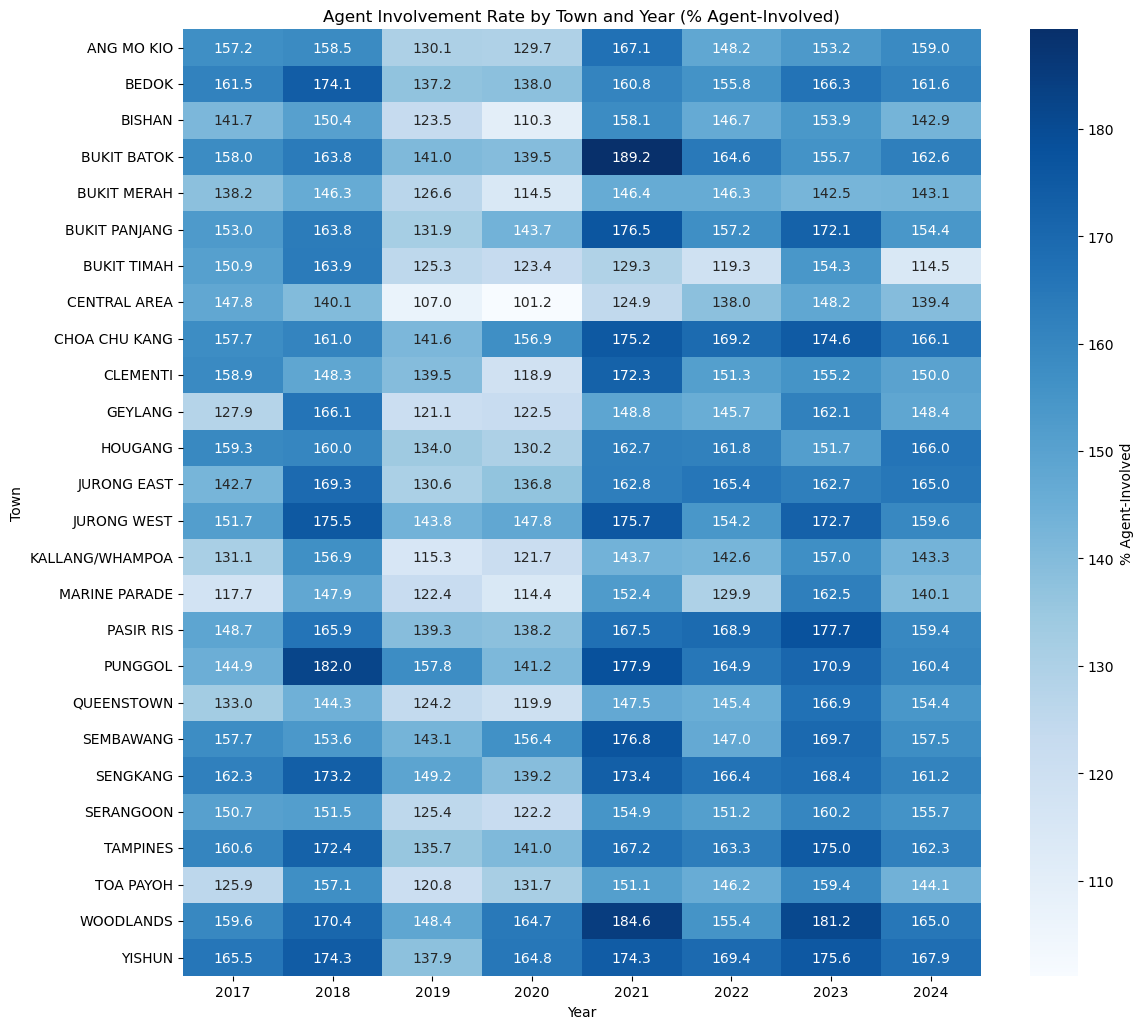

In [ ]:
years = list(range(2017, 2025))
towns = df_hdb['town'].unique()

results = []
for year in years:
    for town in towns:
        total = df_hdb[(df_hdb['year'] == year) & (df_hdb['town'] == town)].shape[0]
        agent = df_cea[(df_cea['year'] == year) & (df_cea['town'] == town)].shape[0]
        direct = total - agent
        pct_agent = (agent / total * 100) if total > 0 else 0
        results.append({'Year': year, 'Town': town, 'Total': total, 'Agent-Involved': agent, 'Direct': direct, '% Agent-Involved': round(pct_agent, 2)})

df_heat = pd.DataFrame(results)

# Pivot for heatmap
heatmap_data = df_heat.pivot(index='Town', columns='Year', values='% Agent-Involved')

# Plotly interactive heatmap
fig = px.imshow(
    heatmap_data,
    labels=dict(x="Year", y="Town", color="% Agent-Involved"),
    x=heatmap_data.columns,
    y=heatmap_data.index,
    color_continuous_scale='Blues',
    aspect="auto",
    title="Agent Involvement Rate by Town and Year (% Agent-Involved)"
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


In [38]:
import pandas as pd
import plotly.express as px

# Calculate the decrease ratio for each town
df_2017_2018 = df_heat[df_heat['Year'].isin([2017, 2018])]
pivot_2017_2018 = df_2017_2018.pivot(index='Town', columns='Year', values='% Agent-Involved')

# Compute the decrease: 2019 - 2018 (negative means a decrease)
pivot_2017_2018['decrease'] = pivot_2017_2018[2018] - pivot_2017_2018[2017]

# Sort towns by decrease (ascending: largest drop at top)
ranking = pivot_2017_2018.sort_values('decrease').reset_index()

# Show the ranking
print("Towns ranked by decrease in agent involvement ratio from 2017 to 2018:")
print(ranking[['Town', 2017, 2018, 'decrease']])

Towns ranked by decrease in agent involvement ratio from 2017 to 2018:
Year             Town    2017    2018  decrease
0            CLEMENTI  158.90  148.35    -10.55
1        CENTRAL AREA  147.80  140.11     -7.69
2           SEMBAWANG  157.71  153.58     -4.13
3             HOUGANG  159.29  160.00      0.71
4           SERANGOON  150.70  151.52      0.82
5          ANG MO KIO  157.22  158.48      1.26
6       CHOA CHU KANG  157.71  160.99      3.28
7         BUKIT BATOK  158.02  163.85      5.83
8         BUKIT MERAH  138.24  146.34      8.10
9              BISHAN  141.70  150.37      8.67
10             YISHUN  165.47  174.26      8.79
11      BUKIT PANJANG  153.03  163.75     10.72
12          WOODLANDS  159.57  170.41     10.84
13           SENGKANG  162.32  173.19     10.87
14         QUEENSTOWN  133.02  144.28     11.26
15           TAMPINES  160.59  172.37     11.78
16              BEDOK  161.50  174.08     12.58
17        BUKIT TIMAH  150.88  163.93     13.05
18          PASIR

In [39]:
import plotly.express as px

fig = px.bar(
    ranking,
    x='Town',
    y='decrease',
    title='Decrease in Agent Involvement Ratio from 2017 to 2018 by Town',
    labels={'decrease': 'Change in % Agent-Involved (2018 - 2017)'},
    text='decrease'
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()